## Table of Contents

### 1. Data Loading and Preprocessing 
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Image Segmentation using Encoder Decoder model + MaxUnpooling + Transpose Convolution
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Calculate IoU score

---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# get images
!unzip /content/drive/My\ Drive/images_BloodCellSegmentation.zip

Archive:  /content/drive/My Drive/images_BloodCellSegmentation.zip
  inflating: images_BloodCellSegmentation/001.bmp  
  inflating: images_BloodCellSegmentation/002.bmp  
  inflating: images_BloodCellSegmentation/003.bmp  
  inflating: images_BloodCellSegmentation/004.bmp  
  inflating: images_BloodCellSegmentation/005.bmp  
  inflating: images_BloodCellSegmentation/006.bmp  
  inflating: images_BloodCellSegmentation/007.bmp  
  inflating: images_BloodCellSegmentation/008.bmp  
  inflating: images_BloodCellSegmentation/009.bmp  
  inflating: images_BloodCellSegmentation/010.bmp  
  inflating: images_BloodCellSegmentation/011.bmp  
  inflating: images_BloodCellSegmentation/012.bmp  
  inflating: images_BloodCellSegmentation/013.bmp  
  inflating: images_BloodCellSegmentation/014.bmp  
  inflating: images_BloodCellSegmentation/015.bmp  
  inflating: images_BloodCellSegmentation/016.bmp  
  inflating: images_BloodCellSegmentation/017.bmp  
  inflating: images_BloodCellSegmentation/018.bmp

In [3]:
# get targets
!unzip /content/drive/My\ Drive/targets_BloodCellSegmentation.zip

Archive:  /content/drive/My Drive/targets_BloodCellSegmentation.zip
  inflating: targets_BloodCellSegmentation/001.png  
  inflating: targets_BloodCellSegmentation/002.png  
  inflating: targets_BloodCellSegmentation/003.png  
  inflating: targets_BloodCellSegmentation/004.png  
  inflating: targets_BloodCellSegmentation/005.png  
  inflating: targets_BloodCellSegmentation/006.png  
  inflating: targets_BloodCellSegmentation/007.png  
  inflating: targets_BloodCellSegmentation/008.png  
  inflating: targets_BloodCellSegmentation/009.png  
  inflating: targets_BloodCellSegmentation/010.png  
 extracting: targets_BloodCellSegmentation/011.png  
 extracting: targets_BloodCellSegmentation/012.png  
  inflating: targets_BloodCellSegmentation/013.png  
  inflating: targets_BloodCellSegmentation/014.png  
  inflating: targets_BloodCellSegmentation/015.png  
  inflating: targets_BloodCellSegmentation/016.png  
 extracting: targets_BloodCellSegmentation/017.png  
 extracting: targets_BloodCellS

In [4]:
# install library
!pip install pytorch-model-summary

In [0]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize

from torch.nn import Sequential, Module
from torch.nn import Conv2d, ReLU, Sigmoid, BatchNorm2d, Dropout
from torch.nn import ConvTranspose2d, MaxPool2d, MaxUnpool2d

from torchvision.models.segmentation import fcn_resnet101

# import model summary
from pytorch_model_summary import summary

In [0]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [0]:
# define filepaths
images_dir = '/content/images_BloodCellSegmentation'
targets_dir = '/content/targets_BloodCellSegmentation'

#### 1.2 Define custom dataset and dataloader

In [0]:
# define custom dataset class
class BloodCellSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir):

        # get all image names
        self.image_names = os.listdir(images_dir)

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, idx):
        
        # read data
        image = Image.open(self.images_paths[idx])
        mask = Image.open(self.masks_paths[idx])

        # preprocess mask
        mask = np.array(mask)
        mask = ((mask == 128) | (mask == 255))
        mask = Image.fromarray(mask)

        # apply data augmentation
        transform = Compose([
                    Resize(224),
                    ToTensor()
                    ])
        
        image = transform(image)
        mask = transform(mask)
        
        return image, mask
        
    def __len__(self):
        return len(self.image_names)

In [0]:
# create instance of custom dataset
dataset = BloodCellSegDataset(images_dir, targets_dir)

# create dataloader
data_loader = DataLoader(
    dataset, 
    batch_size=8,
    num_workers=4,
    shuffle=True
)

#### 1.3 Data Exploration

In [0]:
# check for one iteration of loop
for batch_x, batch_y in data_loader:
    break

In [11]:
# get shapes of batches
batch_x.shape, batch_y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 1, 224, 224]))

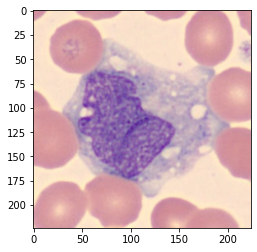

In [12]:
# print image
plt.imshow(np.transpose(batch_x[1], (1, 2, 0)))

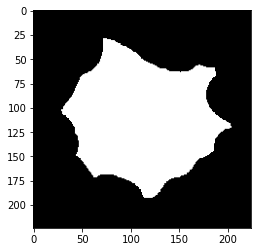

In [13]:
# print mask
plt.imshow(batch_y[1].squeeze(), cmap='gray')

### 2. Image Segmentation using Encoder Decoder model + MaxUnpooling + Transpose Convolution

#### 2.1 Define model architecture

In [0]:
# define model architecture

# Input

# Encoder
## Conv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')
## MaxPool(size=2)
## Conv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')
## MaxPool(size=2)

# Decoder
## MaxUnpool(size=2)
## TransposeConv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')
## MaxUnpool(size=2)
## TransposeConv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')

# Output
## Conv(num_filters=1, filter_size=3, stride=1, padding=1, activation='sigmoid')


class EncoderDecoder(Module):
    def __init__(self):
        super().__init__()

        # define encoder
        self.encoder_block1 = Sequential(
            Conv2d(3, 64, 3, stride=2, padding=1), 
            ReLU()
        )

        self.pool1 = MaxPool2d(2, return_indices=True)

        self.encoder_block2 = Sequential(
            Conv2d(64, 128, 3, stride=2, padding=1), 
            ReLU()
        )

        self.pool2 = MaxPool2d(2, return_indices=True)

        # define decoder        
        self.unpool2 = MaxUnpool2d(2)

        self.decoder_upsample2 = ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity2 = ReLU()

        self.unpool1 = MaxUnpool2d(2)

        self.decoder_upsample1 = ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity1 = ReLU()

        # define output
        self.output_layer = Sequential( 
            Conv2d(64, 1, 3, stride=1, padding=1),
            Sigmoid()
        )

    def forward(self, x):
        # get input shape for encoder block 1
        size_input_encoder_block1 = x.shape
        x = self.encoder_block1(x)
        # get pooling indices of pool 1
        x, indices_pool1 = self.pool1(x)

        # get input shape for encoder block 2
        size_input_encoder_block2 = x.shape
        x = self.encoder_block2(x)
        # get pooling indices of pool 2
        x, indices_pool2 = self.pool2(x)

        # use pooling indices of pool 2
        x = self.unpool2(x, indices_pool2)
        # use input shape of encoder block 2
        x = self.decoder_upsample2(x, output_size=size_input_encoder_block2)
        x = self.decoder_non_linearity2(x)

        # use pooling indices of pool 1
        x = self.unpool1(x, indices_pool1)
        # use input shape of encoder block 1
        x = self.decoder_upsample1(x, output_size=size_input_encoder_block1)
        x = self.decoder_non_linearity1(x)

        x = self.output_layer(x)
        return x

In [0]:
# define model
model = EncoderDecoder()

In [16]:
# print model
model

EncoderDecoder(
  (encoder_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity2): ReLU()
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity1): ReLU()
  (output_layer): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)

In [0]:
# check for one iteration of loop
for batch_x, batch_y in data_loader:
    break

In [18]:
# print model summary
print(summary(model, batch_x[1].unsqueeze(dim=0)))

---------------------------------------------------------------------------------------------
         Layer (type)                           Output Shape         Param #     Tr. Param #
             Conv2d-1                      [1, 64, 112, 112]           1,792           1,792
               ReLU-2                      [1, 64, 112, 112]               0               0
          MaxPool2d-3       [1, 64, 56, 56], [1, 64, 56, 56]               0               0
             Conv2d-4                       [1, 128, 28, 28]          73,856          73,856
               ReLU-5                       [1, 128, 28, 28]               0               0
          MaxPool2d-6     [1, 128, 14, 14], [1, 128, 14, 14]               0               0
        MaxUnpool2d-7                       [1, 128, 28, 28]               0               0
    ConvTranspose2d-8                        [1, 64, 56, 56]          73,792          73,792
               ReLU-9                        [1, 64, 56, 56]         

In [0]:
# check model on one image
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

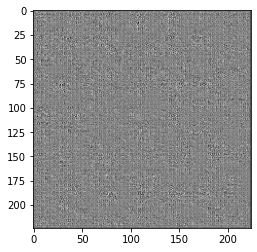

In [20]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 2.2 Train the model

In [0]:
# transfer model to GPU
model = model.to("cuda")

In [0]:
# define optimization and loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
# set model to train
model.train()

# train model
for epoch in range(20):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs, batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 0.6153063980432657 
Training loss for epoch 2 is 0.48862953369434065 
Training loss for epoch 3 is 0.4364316463470459 
Training loss for epoch 4 is 0.37054091691970825 
Training loss for epoch 5 is 0.3494548499584198 
Training loss for epoch 6 is 0.35810800240590024 
Training loss for epoch 7 is 0.3226577158157642 
Training loss for epoch 8 is 0.30785756844740647 
Training loss for epoch 9 is 0.3177718841112577 
Training loss for epoch 10 is 0.3004669478306404 
Training loss for epoch 11 is 0.28095886684381044 
Training loss for epoch 12 is 0.2791169606722318 
Training loss for epoch 13 is 0.3045102529800855 
Training loss for epoch 14 is 0.3134036728968987 
Training loss for epoch 15 is 0.30034394218371463 
Training loss for epoch 16 is 0.2696109918447641 
Training loss for epoch 17 is 0.28242106391833377 
Training loss for epoch 18 is 0.2783198838050549 
Training loss for epoch 19 is 0.27874964819504666 
Training loss for epoch 20 is 0.27730138714496905 


#### 2.3 Calculate IoU score

In [0]:
# get sample data
image = Image.open('/content/images_BloodCellSegmentation/002.bmp')
gt_mask = Image.open('/content/targets_BloodCellSegmentation/002.png')

# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = ((gt_mask == 128) | (gt_mask == 255))
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize(224),
            ToTensor()
            ])
        
image = transform(image)

gt_mask = transform(gt_mask)

In [0]:
# get prediction
model.eval()
output = model(image.unsqueeze(dim=0).to('cuda')).cpu().detach().numpy()

In [26]:
# print shape
output.shape

(1, 1, 224, 224)

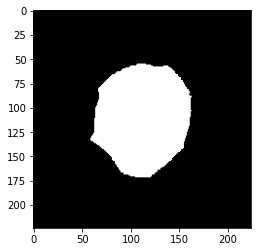

In [27]:
# plot ground truth mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

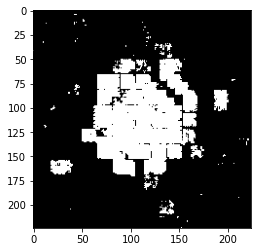

In [28]:
# plot predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [29]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for WBC
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.6828481784905003